# Difficulty Classification

Goal:
* Classify a task for a given student as too difficult or ok.

Data:
- Robotanist, order and times of solved tasks
- proxy for "too difficult" = spent more than 10 minutes


Notes:
- The threshold of 10 minutes is arbitraty. It was chosen as it's easily interpretable even for users and because it makes the problem highly unbalanced (there are only about 5% of difficult labels), which makes this project a good training of how to deal with this common scenario.


Usage:
- hard recommendation: filter/lock too difficult tasks
- soft recommendation: indicate too difficult task (e.g. via red color or coarse time predictions)
- set challenge level (e.g. 5m if ok, 15m for too difficult)


Extensions:
* Ideally, the same methods should be usable in scenario where  explicit user information (qualitative data) about perceived difficulty are available.
* Second classifier for too easy tasks (e.g. < 1 minute).
* Use content-based features (e.g. length of the optimal solution, number of world-features).

In [17]:
%matplotlib inline
from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

# Data

In [55]:
ordering = pd.read_csv('../data/robotanik/user_time_ordering.csv', index_col='Login')
# Make task IDs integers (from string labels).
ordering.columns = map(int, ordering.columns)
# Remove tasks with not enough data.
ordering = ordering.dropna(axis=1, thresh=40)
ordering.head()

,635,636,637,638,639,640,641,642,643,644,...,1124,1125,1401,1402,1403,1404,1704,1705,1706,1707
Login,,,,,,,,,,,,,,,,,,,,,
U1,1.0,2.0,13.0,5.0,NaN,9.0,NaN,NaN,NaN,10.0,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U2,1.0,2.0,4.0,3.0,5.0,6.0,9.0,10.0,8.0,11.0,...,37.0,43.0,57.0,NaN,NaN,NaN,58.0,59.0,60.0,61.0
U4,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U5,1.0,2.0,3.0,4.0,16.0,5.0,15.0,NaN,11.0,13.0,...,21.0,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U6,1.0,2.0,3.0,7.0,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
times = pd.read_csv('../data/robotanik/user_time.csv', index_col='Login')
# Make task IDs integers (from string labels).
times.columns = map(int, times.columns)
# Infere "true labels" (too difficult case)
TOO_DIFFICULT_THRESHOLD_MINUTES = 10
labels = times > 60 * TOO_DIFFICULT_THRESHOLD_MINUTES
#labels.head()
# We will work with log times.
times = times.applymap(np.log)
times.head()

,635,636,637,638,639,640,641,642,643,644,...,1402,1403,1404,1405,1406,1407,1704,1705,1706,1707
Login,,,,,,,,,,,,,,,,,,,,,
U1,3.218876,2.564949,2.639057,3.637586,NaN,6.129050,NaN,NaN,NaN,4.882802,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U2,2.302585,1.609438,3.891820,2.944439,4.521789,3.135494,4.043051,3.688879,3.737670,5.351858,...,NaN,NaN,NaN,NaN,NaN,NaN,5.220356,4.727388,3.583519,4.290459
U4,3.258097,1.791759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U5,3.951244,3.663562,3.218876,2.944439,5.897154,3.218876,4.595120,NaN,4.025352,3.828641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U6,4.219508,2.995732,3.465736,2.890372,NaN,3.737670,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


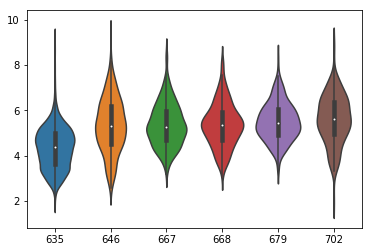

In [4]:
# distribution of log-times
# NOTE: this kind of analysis should be performed on the data without
# the test set to avoid data snooping
sns.violinplot(data=times[[635, 646, 667, 668, 679, 702]])

The dataset contains about 10K of users and 80 tasks.

In [57]:
print('users:', ordering.shape[0])
print('tasks:', ordering.shape[1])
print('interactions:', sum(ordering.count()))

users: 10463
tasks: 70
interactions: 121026


# Interactions

Let's transform the pivoted tables into raw time series of student-task interaction.

In [58]:
def get_events_series():
    data = []
    for user_id in ordering.index:
        order = ordering.loc[user_id].dropna().sort_values()
        for task_id, student_order in order.items():
            event = OrderedDict(
                student_id=int(user_id[2:]),
                student_order=int(student_order),
                task_id=int(task_id),
                time=times.loc[user_id, task_id],
                label=labels.loc[user_id, task_id])
            data.append(event)
    events = pd.DataFrame(data)
    return events

raw_events = get_events_series()
print(raw_events.shape)
raw_events.head()

(121026, 5)


,student_id,student_order,task_id,time,label
0,1,1,635,3.218876,False
1,1,2,636,2.564949,False
2,1,3,656,4.595120,False
3,1,4,698,3.850148,False
4,1,5,638,3.637586,False


# Train-test split

Before doing anything else, we split all interactions into a training set and test set, so that we are able to perform unbiased final evaluation.

We will assume independence between users (which is a reasonable assumption). For a single user, we avoid "predicting past from the future" by a user-stratified split, i.e. we select a random subset of students a puts all their interactions into the test set.

In [69]:
student_ids = pd.Series(raw_events.student_id.unique())
train_student_ids = student_ids.sample(frac=0.7)
train_flags = raw_events.student_id.isin(train_student_ids)
raw_train_events = raw_events[train_flags]
raw_test_events = raw_events[~train_flags]
print('train events:', len(raw_train_events))
print('test events:', len(raw_test_events))

train events: 85281
test events: 35745


# Features

Let us precompute several features, which we will use in the subsequent experiments:

Student-related (skill):
- average student delta from average task time
- number of solved tasks
- ratio of too-difficult interactions
- the most difficult solved task [in ok mode]
- which tasks solved [in which mode] / log-times / quartiles

Task-related (difficulty):
- average/median solving time of the task
- percentage of students who have solved the task
- percentage of too difficult attempts
- mean/median order

(Note: all times are log-scaled).

Steps:
1. To compute task features, use the training set.
2. To compute student featues, use past history of the student in the current evaluation set.

This corresponds to the real-world scenario, in which the task features are preocomputed offline from the historical data, while the student features are computed online, immidiatelly as the student learns.

In [60]:
def compute_task_features(events_train, normalize=False):
    tasks = events_train.groupby('task_id')
    n_students = events_train.student_id.nunique()
    n_tasks = events_train.task_id.nunique()
    task_features = pd.DataFrame(OrderedDict(
      task_time_avg=tasks.time.mean(),
      task_time_med=tasks.time.median(),
      task_unsolved=1 - tasks.time.count() / n_students,
      task_difficult=tasks.label.mean(),
      task_order_avg=tasks.student_order.mean(),
      task_order_med=tasks.student_order.median(),
    ))
    # Note: normalization should be added to the classifier pipeline
    # (student-features derivation requires original features).
    if normalize:
        task_features = pd.DataFrame(
            preprocessing.scale(task_features),
            index=task_features.index,
            columns=task_features.columns)
    return task_features

task_features = compute_task_features(raw_train_events, normalize=False)
task_features.head()

,task_time_avg,task_time_med,task_unsolved,task_difficult,task_order_avg,task_order_med
task_id,,,,,,
635,4.333587,4.369448,0.078646,0.010670,1.010966,1.0
636,3.229315,3.091042,0.191289,0.001351,2.754854,2.0
637,4.482672,4.369448,0.437739,0.027683,7.773434,8.0
638,4.308863,4.343805,0.335063,0.026694,5.476386,5.0
639,5.174380,5.117994,0.886128,0.098321,19.353717,20.0


These precomputed features correlate a lot (see the pair-plot below), which means that it probably won't be much beneficial to use more than one of them.

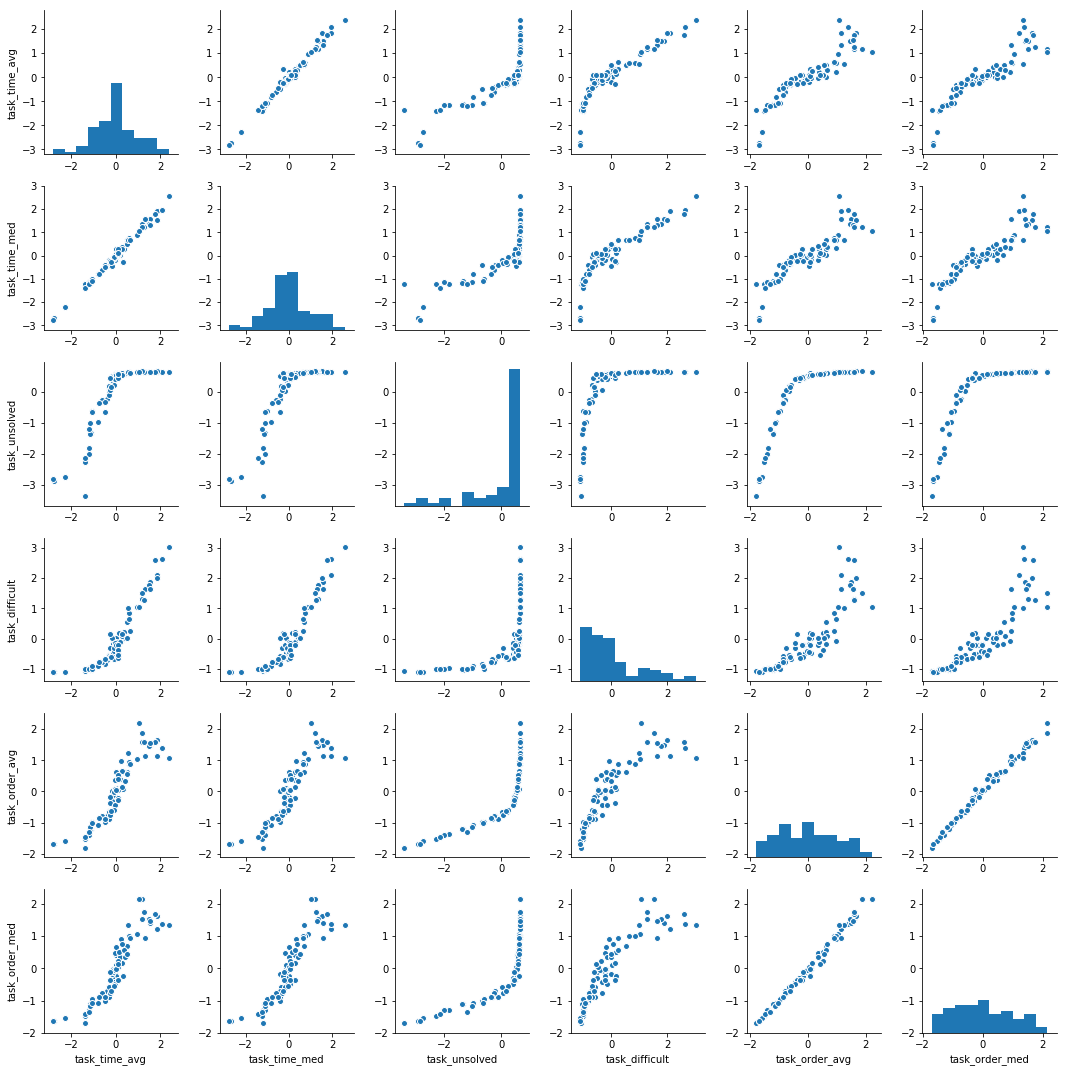

In [9]:
#task_features.task_time_med.plot.hist()
sns.pairplot(task_features)

Now let's derive and join student features:

In [89]:
class Student:
    def __init__(self):
        self.solved_count = 0
        self.timedelta_sum = 0
        self.too_difficult_count = 0

        
    def update(self, event):
        """Process a single event (with merged task features).
        """
        self.solved_count += 1
        # For consistency, all student measures are increasing
        # with their skill; hence the positive delta means how much
        # faster they solved the task than is its average time difficulty.
        timedelta = event.task_time_avg - event.time
        self.timedelta_sum += timedelta
        self.too_difficult_count += int(event.label)
        
    @property
    def timedelta_avg(self):
        if self.solved_count == 0:
            return 0
        return self.timedelta_sum / self.solved_count
    
    @property
    def difficult_perc(self):
        if self.solved_count == 0:
            return 0
        return self.too_difficult_count / self.solved_count
        
    @property
    def features(self):
        return {
            'student_timedelta_avg': self.timedelta_avg,
            'student_difficult_perc': self.difficult_perc,
        }

def join_task_features(events):
    events = pd.merge(events, task_features, left_on='task_id', right_index=True)
    events.sort_values(by=['student_id', 'student_order'], inplace=True)
    return events
    
    
def add_student_features(events):
    """Extend each event features computed "online" for each student.
    """
    students = defaultdict(Student)
    student_features = []
    for i, event in events.iterrows():
        student = students[event.student_id]
        # It's important to append features to the current event
        # BEFORE the student is updated (to avoid cheating).
        student_features.append(student.features)
        student.update(event)
    student_features = pd.DataFrame(student_features, index=events.index)
    return pd.concat([events, student_features], axis=1)


def add_derived_features(events):
    """Extend each event with computed features.
    """
    events = join_task_features(events)
    events = add_student_features(events)
    return events


events_train = add_derived_features(raw_train_events)
events_test = add_derived_features(raw_test_events)
events_train.head(10)

,student_id,student_order,task_id,time,label,task_time_avg,task_time_med,task_unsolved,task_difficult,task_order_avg,task_order_med,student_difficult_perc,student_timedelta_avg
0,1,1,635,3.218876,False,4.333587,4.369448,0.078646,0.010670,1.010966,1.0,0.0,0.000000
1,1,2,636,2.564949,False,3.229315,3.091042,0.191289,0.001351,2.754854,2.0,0.0,1.114711
2,1,3,656,4.595120,False,4.537187,4.488636,0.550382,0.018220,10.125418,11.0,0.0,0.889538
3,1,4,698,3.850148,False,4.518202,4.418841,0.545330,0.018318,10.411712,11.0,0.0,0.573714
4,1,5,638,3.637586,False,4.308863,4.343805,0.335063,0.026694,5.476386,5.0,0.0,0.597299
5,1,6,1124,2.639057,False,3.169527,3.044522,0.206445,0.001721,2.873193,2.0,0.0,0.612095
6,1,7,1120,4.174387,False,4.325056,4.219508,0.365511,0.023241,6.078115,6.0,0.0,0.598491
7,1,8,1119,5.308268,False,3.610639,3.496508,0.222010,0.001755,4.081432,4.0,0.0,0.534516
8,1,9,640,6.129050,False,4.477284,4.430817,0.396232,0.023293,7.237223,8.0,0.0,0.255498
9,1,10,644,4.882802,False,5.210914,5.257495,0.856772,0.127741,18.911344,20.0,0.0,0.043580


# Two Features Experiment (avg times)

For the first experiment, I have decied to use only 2 features to allow for plotting the results into 2D plots to gain some intuition. One features is related to the objective task difficulty, one to the student skill:
1. average solving time of the task
2. average student delta from average task time

(Note: all times are log-scaled.)

First, let's see distribution of events wrt. these two features:

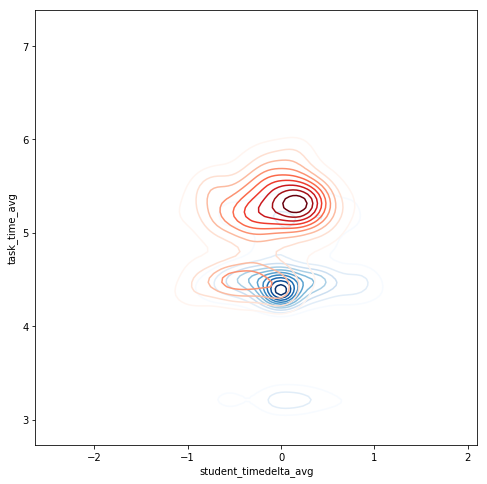

In [91]:
positives = events_train.query("label == True").sample(500)
negatives = events_train.query("label == False").sample(500)

# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(
    negatives.student_timedelta_avg,
    negatives.task_time_avg,
    cmap="Blues", shade=False, shade_lowest=False)
ax = sns.kdeplot(
    positives.student_timedelta_avg,
    positives.task_time_avg,
    cmap="Reds", shade=False, shade_lowest=False)

# Add labels to the plot
# red = sns.color_palette("Reds")[-2]
# blue = sns.color_palette("Blues")[-2]
# ax.text(0.2, 0.9, "not-difficult", size=16, color=blue)
# ax.text(0.4, -0.1, "difficult", size=16, color=red)

## Comparing models

goal: compare performance of different models x different features
and explore various evaluation metrics and how much they agree with each other

todo: add evaluation metrics suitable for unbalanced problems

In [61]:
def train_model(model, features):
    X = events_train[features]
    y = events_train.label
    model.fit(X, y)
    return model

def get_test_labels_and_scores(model, features):
    X_test = events_test[features]
    y_test = events_test.label
    #y_scores = model.decision_function(X_test)
    y_scores = model.predict_proba(X_test)[:,1]
    return y_test, y_scores

def eval_model(model, features):
    X_test = events_test[features]
    y_test = events_test.label
    class_predictions = model.predict(X_test)
    accuracy = np.mean(class_predictions == y_test)
    return {
        'accuracy': accuracy
    }    
    
models = [
    ('constant', DummyClassifier(strategy='most_frequent'),
     ['student_id']),
    ('task-avg', LogisticRegression(),
     ['task_time_avg']),
    ('student-avg', LogisticRegression(),
     ['student_timedelta_avg']),
    ('logreg', LogisticRegression(),
     ['student_timedelta_avg', 'task_time_avg']),
    ('perceptron', Perceptron(max_iter=1000, tol=0.0001),
     ['student_timedelta_avg', 'task_time_avg']),
    ('lda', LinearDiscriminantAnalysis(solver="svd"),
     ['student_timedelta_avg', 'task_time_avg']),
    ('qda', QuadraticDiscriminantAnalysis(),
     ['student_timedelta_avg', 'task_time_avg']),
]

results = {}
for name, model, features in models:
    model = train_model(model, features)
    results[name] = eval_model(model, features)
    print(name, results[name])    

constant {'accuracy': 0.95765772688849615}
task-avg {'accuracy': 0.9580163426317273}
student-avg {'accuracy': 0.95765772688849615}
logreg {'accuracy': 0.95717103409411097}
perceptron {'accuracy': 0.68208714362560519}
lda {'accuracy': 0.95783703476011173}
qda {'accuracy': 0.9579138809908041}


## Logistic Regression

In [40]:
clf = LogisticRegression()
clf = train_model(clf, ['student_timedelta_avg'])
print(clf.intercept_, clf.coef_)
# Both intercpet and skill coeff are negative -> always prediciting not-difficult (same as dummy classifier)

[-2.91065616] [[-0.57819272]]


In [42]:
clf = LogisticRegression()
clf = train_model(clf, ['task_time_avg'])
print(clf.intercept_, clf.coef_)

[-12.79045591] [[ 2.04985799]]


In [43]:
clf = LogisticRegression()
clf = train_model(clf, ['task_time_avg', 'student_timedelta_avg'])
print(clf.intercept_, clf.coef_)

[-14.28175381] [[ 2.34840587 -1.41077362]]


We want penalize false negatives more than false positives - it's ok to lock some not-difficult tasks, it's bad not to lock too dificult tasks. [not clear] So recall (sensitivity) is more imporatant than precision.

First step: measure recall, precision, auc-pr

In [67]:
# TODO: compute confusion matrix, precision, recall, f1, PR curves
# add these metrics to the evalution above

confusion_matrix(y_true, y_pred)

NameError: name 'y_true' is not defined

Average precision-recall score: 0.02


Text(0.5,1,'2-class Precision-Recall curve: AP=0.02')

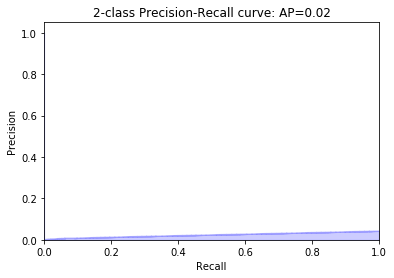

In [62]:
clf = LogisticRegression()
features = ['task_time_avg', 'student_timedelta_avg']
clf = train_model(clf, features)
y_test, y_scores = get_test_labels_and_scores(model, features)


average_precision = average_precision_score(y_test, y_scores)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

## Perceptron

In [27]:
# # original experiment with different features
# model = Perceptron(max_iter=1000, tol=0.0001, fit_intercept=True)
# features = ['student_solved_percentage', 'task_solved_percentage']
# train_model(model, features)
# print(eval_model(model, features))
# print('Weights:', model.coef_)
# print('Intercept:', model.intercept_)

Observations:
* Feature `task_solved_percentage` is 7-times more important than `student_solved_percentage`.
* The fact that the student has solved more tasks is positively correlated with the task beign labeled as too difficult. This is proably caused by the *self-selection bias*: students with more solved tasks attempt tasks at the end of the list, and these tasks are more time consuming. So this result suggests that the `student_solved_percentage` is a dangerour feauture and should not be used.

In [28]:
clf = Perceptron(max_iter=10000, tol=0.00001, fit_intercept=True)
features = ['student_timedelta_avg', 'task_time_avg']
train_model(clf, features)
print(eval_model(clf, features))
print('Weights:', clf.coef_)
print('Intercept:', clf.intercept_)

{'accuracy': 0.68208714362560519}
Weights: [[-10.25465427  20.22007572]]
Intercept: [-93.]


Text(0.5,1,'Perceptron')

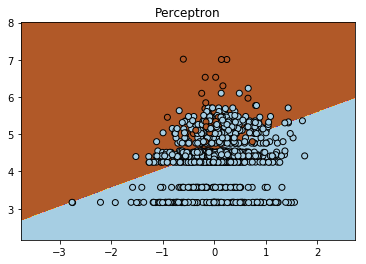

In [29]:
# Plot decision boundary
# Source: https://stats.stackexchange.com/questions/71335/decision-boundary-plot-for-a-perceptron
some_events = events_train.sample(1000)
X = some_events[features].values
y = some_events.label.values
h = 0.02
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
fig, ax = plt.subplots()
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

ax.set_title('Perceptron')

## LDA and QDA

FDA = LDA for 2 classes (?)

In [30]:
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
features = ['student_timedelta_avg', 'task_time_avg']
train_model(lda, features)
print(eval_model(lda, features))

qda = QuadraticDiscriminantAnalysis(store_covariance=True)
train_model(qda, features)
print(eval_model(qda, features))

{'accuracy': 0.95783703476011173}
{'accuracy': 0.9579138809908041}


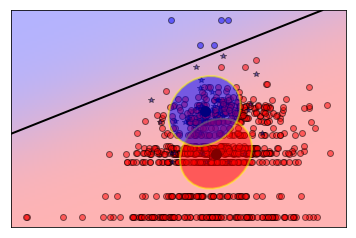

In [31]:
# plots (X and y taken from the previeous section)
# taken from scikit-learn http://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html) 

from scipy import linalg
from matplotlib import colors
import matplotlib as mpl
# #############################################################################
# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)
# #############################################################################
# Plot functions
def plot_data(lda, X, y, y_pred):
    splot = plt.subplot()
    
    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    alpha = 0.5

    # class 0: dots
    plt.plot(X0_tp[:, 0], X0_tp[:, 1], 'o', alpha=alpha,
             color='red', markeredgecolor='k')
    plt.plot(X0_fp[:, 0], X0_fp[:, 1], '*', alpha=alpha,
             color='#990000', markeredgecolor='k')  # dark red

    # class 1: dots
    plt.plot(X1_tp[:, 0], X1_tp[:, 1], 'o', alpha=alpha,
             color='blue', markeredgecolor='k')
    plt.plot(X1_fp[:, 0], X1_fp[:, 1], '*', alpha=alpha,
             color='#000099', markeredgecolor='k')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.))
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='k')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             'o', color='black', markersize=10, markeredgecolor='k')
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             'o', color='black', markersize=10, markeredgecolor='k')

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='yellow',
                              linewidth=2, zorder=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariances_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariances_[1], 'blue')


y_pred = lda.predict(X)
splot = plot_data(lda, X, y, y_pred)
plot_lda_cov(lda, splot)

/home/xeffenb1/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function covariances_ is deprecated; Attribute covariances_ was deprecated in version 0.19 and will be removed in 0.21. Use covariance_ instead
  warnings.warn(msg, category=DeprecationWarning)
/home/xeffenb1/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function covariances_ is deprecated; Attribute covariances_ was deprecated in version 0.19 and will be removed in 0.21. Use covariance_ instead
  warnings.warn(msg, category=DeprecationWarning)


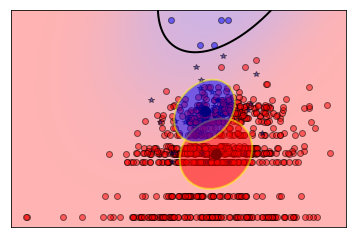

In [32]:
y_pred = qda.predict(X)
splot = plot_data(qda, X, y, y_pred)
plot_qda_cov(qda, splot)

# Failures and Lessons Learned

### Beware of Self-Selection Bias

In the first experiment, I used the following 2 featues:
1. how many tasks has the student already solved (student_solved_percentage)
2. how many students have solved the task (task_solved_percentage)

Due to self-selection bias, student_solved_percentage correlated positively with too difficult task. As a result, the more the student solved, the more "too dificult" predictions he would obtain, which doesn't make sense.


### Don't Use Accuracy and AUC for Unbalanced Problems

For unbalanced problems, these are nearly 1 for the majority-class predictors, which are useless. Metrics derived from the confusion metrics (true/false positive rate, positive/negative predictive power and their combinations) need to be considered.